In [ ]:
# =====================================
# Train Water Quality Risk Assessment Model
# =====================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import os

In [12]:
file_path = r"D:\workshop 2025\project\datasets\DS4\Water_pond_tanks_2021.xlsx"

df = pd.read_excel(file_path)

print(df.head())


   STN\nCode                        Name of Monitoring Location  \
0     4368.0      KOLLERU LAKE KOKKIRAYALANKA (V), KAILALUR (M)   
1     2353.0  KONDAKARLA-AAVA LAKE, PARAWADA PHARMA CITY, VI...   
2     1790.0                       PULICATE LAKE , NELLORE DIST   
3     4391.0      CHENGAMBAKAM TANK IN SRI CITY SEZ,\nTIRUPATHI   
4     4921.0           ANNAMAYYA PROJECT ON CHEYYERU\nRESERVOIR   

  Type Water Body      State Name  Temperature\n?C (Min)  \
0            LAKE  ANDHRA PRADESH                   24.0   
1            LAKE  ANDHRA PRADESH                   26.0   
2            LAKE  ANDHRA PRADESH                   18.0   
3            TANK  ANDHRA PRADESH                   22.0   
4         Wetland  ANDHRA PRADESH                   21.0   

   Temperature\n?C (Max) Dissolved Oxygen (mg/L) (Min)  \
0                   27.0                           3.2   
1                   29.0                             3   
2                   24.0                           4.2   
3   

In [ ]:
# Clean column names (strip spaces, replace \n etc.)
df.columns = df.columns.str.replace("\n", " ").str.strip()

# Features we care about
features = [
    "Temperature ?C (Min)", "Temperature ?C (Max)",
    "Dissolved Oxygen (mg/L) (Min)", "Dissolved Oxygen (mg/L) (Max)",
    "pH (Min)", "pH (Max)",
    "Conductivity (?mhos/cm) (Min)", "Conductivity (?mhos/cm) (Max)",
    "BOD (mg/L) (Min)", "BOD (mg/L) (Max)",
    "Nitrate N + Nitrite N(mg/L) (Min)", "Nitrate N + Nitrite N(mg/L) (Max)",
    "Fecal Coliform (MPN/100ml) (Min)", "Fecal Coliform (MPN/100ml) (Max)",
    "Total Coliform (MPN/100ml) (Min)", "Total Coliform (MPN/100ml) (Max)"
]

In [15]:
# Convert relevant columns to numeric (force errors to NaN)
numeric_cols = [
    "Dissolved Oxygen (mg/L) (Min)",
    "Dissolved Oxygen (mg/L) (Max)",
    "pH (Min)",
    "pH (Max)",
    "Conductivity (?mhos/cm) (Max)",
    "BOD (mg/L) (Max)",
    "Nitrate N + Nitrite N(mg/L) (Max)",
    "Fecal Coliform (MPN/100ml) (Max)",
    "Total Coliform (MPN/100ml) (Max)"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Define risk assessment
def assess_risk(row):
    score = 0
    
    if row["Dissolved Oxygen (mg/L) (Min)"] < 3: score += 1
    if row["pH (Min)"] < 6.5 or row["pH (Max)"] > 8.5: score += 1
    if row["Conductivity (?mhos/cm) (Max)"] > 1500: score += 1
    if row["BOD (mg/L) (Max)"] > 3: score += 1
    if row["Nitrate N + Nitrite N(mg/L) (Max)"] > 3: score += 1
    if row["Fecal Coliform (MPN/100ml) (Max)"] > 50: score += 1
    if row["Total Coliform (MPN/100ml) (Max)"] > 500: score += 1
    
    if score <= 2:
        return "Low"
    elif score <= 4:
        return "Moderate"
    else:
        return "High"

# Apply risk classification
df["RiskLevel"] = df.apply(assess_risk, axis=1)

print(df[["Name of Monitoring Location", "RiskLevel"]].head())

                         Name of Monitoring Location RiskLevel
0      KOLLERU LAKE KOKKIRAYALANKA (V), KAILALUR (M)  Moderate
1  KONDAKARLA-AAVA LAKE, PARAWADA PHARMA CITY, VI...       Low
2                       PULICATE LAKE , NELLORE DIST       Low
3      CHENGAMBAKAM TANK IN SRI CITY SEZ,\nTIRUPATHI  Moderate
4           ANNAMAYYA PROJECT ON CHEYYERU\nRESERVOIR       Low


In [21]:
df = df.dropna(subset=numeric_cols)  # simplest option for now

X = df[numeric_cols]
y = df["RiskLevel"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.926605504587156

Classification Report:
               precision    recall  f1-score   support

        High       0.89      0.91      0.90        34
         Low       0.97      1.00      0.99        38
    Moderate       0.91      0.86      0.89        37

    accuracy                           0.93       109
   macro avg       0.92      0.93      0.92       109
weighted avg       0.93      0.93      0.93       109


Confusion Matrix:
 [[31  0  3]
 [ 0 38  0]
 [ 4  1 32]]


In [23]:
import joblib
joblib.dump(model, "water_pollution_model.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [25]:
# Drop columns we don't need (like locations, names, IDs, etc.)
# Keep only numeric features + RiskLevel (target)
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Ensure RiskLevel is kept separately
X = df[numeric_cols]
y = df["RiskLevel"]

# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(model, "water_quality_model.pkl")
print("✅ Water Quality model saved as 'water_quality_model.pkl'")


Classification Report:
               precision    recall  f1-score   support

        High       0.91      0.81      0.86        37
         Low       0.97      1.00      0.98        32
    Moderate       0.84      0.90      0.87        40

    accuracy                           0.90       109
   macro avg       0.91      0.90      0.90       109
weighted avg       0.90      0.90      0.90       109


Confusion Matrix:
 [[30  0  7]
 [ 0 32  0]
 [ 3  1 36]]
✅ Water Quality model saved as 'water_quality_model.pkl'


Accuracy: 0.8990825688073395

Classification Report:
               precision    recall  f1-score   support

        High       0.91      0.81      0.86        37
         Low       0.97      1.00      0.98        32
    Moderate       0.84      0.90      0.87        40

    accuracy                           0.90       109
   macro avg       0.91      0.90      0.90       109
weighted avg       0.90      0.90      0.90       109



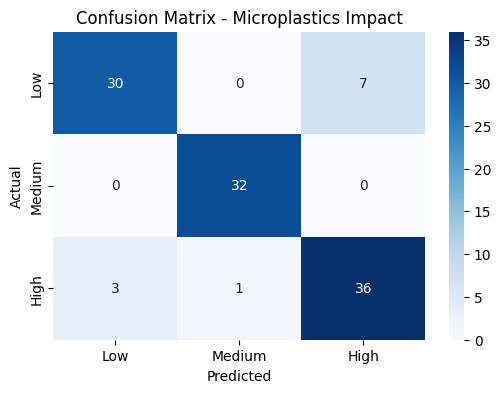

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Microplastics Impact')
plt.show()


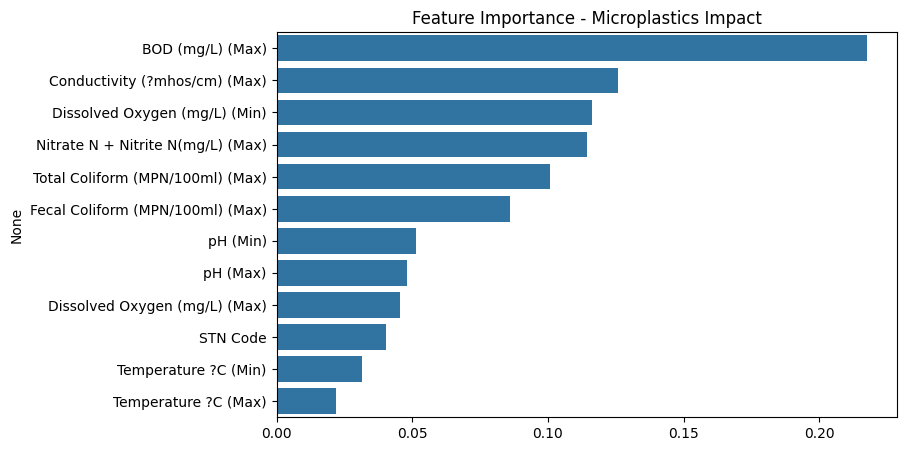

In [27]:
import numpy as np

# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importance - Microplastics Impact")
plt.show()


In [28]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV Score:", scores.mean())


Cross-validation scores: [0.79816514 0.86238532 0.86238532 0.81651376 0.7706422 ]
Mean CV Score: 0.8220183486238533
